# sample1

We use [DestVI](https://www.nature.com/articles/s41587-022-01272-8) and a single cell referenece dataset to infere the cell types present on each spot.

Here are the libraries we need.

In [1]:
from os import makedirs, remove, rmdir
from os.path import exists, join
from scipy.sparse import csr_matrix, issparse
from scvi.model import CondSCVI, DestVI

import anndata
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc
import session_info

Global seed set to 0


Some useful function to save AnnData objects and models.

In [2]:
###############################################
def save_anndata(anndata_object, num, suffix):#
###############################################
   if not issparse(anndata_object.X):
      anndata_object.X = csr_matrix(anndata_object.X)
   anndata_object.write_h5ad( join("output/h5ad", f"anndata.{num}.{suffix}.h5") )
   ###########################################################################

#################################################
def save_model(model_object, directory, suffix):#
#################################################

   model_dir = join(directory, f"model_{suffix}")
   model_archive = join(model_dir, "model.pt")

   if exists(model_archive):
      remove(model_archive)

   if exists(model_dir):
      rmdir(model_dir)

   model_object.save(model_dir)
   ###########################################################################

############################
def has_zeros(name, adata):#
############################
   genes = np.sum( 0 == np.sum(adata.X, axis=0) )
   cells = np.sum( 0 == np.sum(adata.X, axis=1) )
   print(f"{name}: {genes} zeros for genes and {cells} zeros for cells")

We create the output directory for this noteboook.
Every outputs will save there.

In [3]:
try:
   makedirs("output/h5ad")
except OSError as e:
   pass

Configuration of scanpy.

In [4]:
sc.settings.figdir = "output"
sc.set_figure_params(figsize=(4, 4), frameon=False)

## scRNA-seq reference dataset preprocessing

### Loading

We load the single-cell reference dataset.

In [5]:
sc_adata = sc.read_10x_mtx("reference", var_names="gene_symbols")

args = {
   "filepath_or_buffer": join("reference", "types.tsv.gz"),
   "header": None,
   "compression": "gzip"
}
types = pd.read_csv(**args).rename(columns={0: "Type"})
types.index = sc_adata.obs_names
sc_adata.obs = types

sc_adata

AnnData object with n_obs × n_vars = 113507 × 20310
    obs: 'Type'
    var: 'gene_ids', 'feature_types'

### Gene symbols

We use the gene symbols as IDs and put convert everything to upper case.
So, we also need to check that are no duplicates in gene symbols.

In [6]:
sc_adata.var_names = sc_adata.var_names.str.upper()
sc_adata = sc_adata[ : , ~ sc_adata.var_names.duplicated() ]

### Minimum counts

We need to remove the spots and the genes with no count.

In [7]:
sc_adata = sc_adata[ : , ~ np.all(sc_adata.X.toarray() == 0, axis=0) ]
sc_adata = sc_adata[ ~ np.all(sc_adata.X.toarray() == 0, axis=1) , : ]

save_anndata(sc_adata, "00", "raw")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


We remove the spots with too few UMIs.

In [8]:
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.layers["counts"] = sc_adata.X.copy()

save_anndata(sc_adata, "01", "min_counts")

### Variable genes

We select the most variable genes.
This selection can create spots with no counts.
So, we need to remove these spots.

In [9]:
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc_adata.layers["counts"] = sc_adata.X.copy()
sc_adata = sc_adata[ ~ np.all( sc_adata.X.toarray() == 0 , axis=1 ) , : ]
sc_adata.layers["counts"] = sc_adata.X.copy()

save_anndata(sc_adata, "02", "var_genes")

### Normalization and log-transformation

We normalize and log-transform the counts.

In [10]:
sc.pp.normalize_total(sc_adata, target_sum=10e4)
save_anndata(sc_adata, "03", "normalized")

sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata
save_anndata(sc_adata, "04", "logtransformed")

## The sample

### Loading

We load the sample count and spatial data and create an AnnData object.

In [11]:
spatial = pd.read_csv("sample1.csv").set_index("Barcode")

st_adata = sc.read_10x_mtx("sample1", var_names="gene_symbols")
st_adata.obs = spatial.loc[ st_adata.obs.index ]
st_adata = st_adata[ : , ~ np.all(st_adata.X.toarray() == 0, axis=0) ]

### Preprocessing

We need to apply the same preprocessing as with the scRNA-seq reference dataset.
So, we convert the gene symbols to upper case.
Then, we normalize, log-transform the counts and remove the duplicates.

In [12]:
st_adata.var_names = st_adata.var_names.str.upper()

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

st_adata.raw = st_adata

sc_adata = sc_adata[ : , ~ sc_adata.var.index.duplicated(keep=False) ]
st_adata = st_adata[ : , ~ st_adata.var.index.duplicated(keep=False) ]

## Common genes

We select only the genes that are common to the sample and the reference.
The number of genes can end up being quite low because we took only the most variable genes.

In [13]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)

print("{0} genes in common over {1}".format(len(intersect), sc_adata.shape[1]))

adata = sc_adata[:, intersect].copy()
adata = adata[ ~ np.all( adata.X.toarray() == 0 , axis=1 ) , : ]
adata.layers["counts"] = adata.X.copy()

st_adata = st_adata[:, intersect].copy()
st_adata = st_adata[ ~ np.all(st_adata.X.toarray() == 0, axis=1) , :]
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm["spatial"] = st_adata.obs[["x", "y"]].to_numpy()

has_zeros("refeference", adata)
has_zeros("spatial", st_adata)

1841 genes in common over 2000
refeference: 0 zeros for genes and 0 zeros for cells
spatial: 0 zeros for genes and 0 zeros for cells


## Single-cell model training

We can now set up the single-cell model.

In [14]:
adata.obs["Type"] = adata.obs.Type.astype(str) # CondSCVI fails otherwise
CondSCVI.setup_anndata(adata, layer="counts", labels_key="Type")
sc_model = CondSCVI(adata, weight_obs=False)
sc_model.view_anndata_setup()

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


Anndata setup with scvi-tools version 0.16.4.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'Type', 'layer': 'counts'}

     Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Summary Stat Key ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│     n_cells      │ 113507 │
│      n_vars      │  1841  │
│     n_labels     │   18   │
└──────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃      Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Type'] │       Astrocyte       │          0          │
│                   │          CA1          │          1          │
│                   │          CA3          │          2          │
│                   │     Cajal_Retzius     │          3          │
│                   │        Choroid        │          4          │
│                   │        Denate         │          5          │
│                   │   Endothelial_Stalk   │          6          │
│                   │    Endothelial_Tip    │          7          │
│                   │      Entorihinal      │          8          │
│                   │       Ependymal       │          9          │
│                   │      Interneuron      │         10          │
│                   │ Microglia_Macrophages │         11          │
│                   │         Mural         │         12          │
│                   │     Neurogenesis      │         13          │
│                   │    Neuron.Slc17a6     │         14          │
│                   │    Oligodendrocyte    │         15          │
│                   │    Polydendrocyte     │         16          │
│                   │          nan          │         17          │
└───────────────────┴───────────────────────┴─────────────────────┘

We train the model here.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [16:49<00:00,  6.73s/it, loss=659, v_num=1]


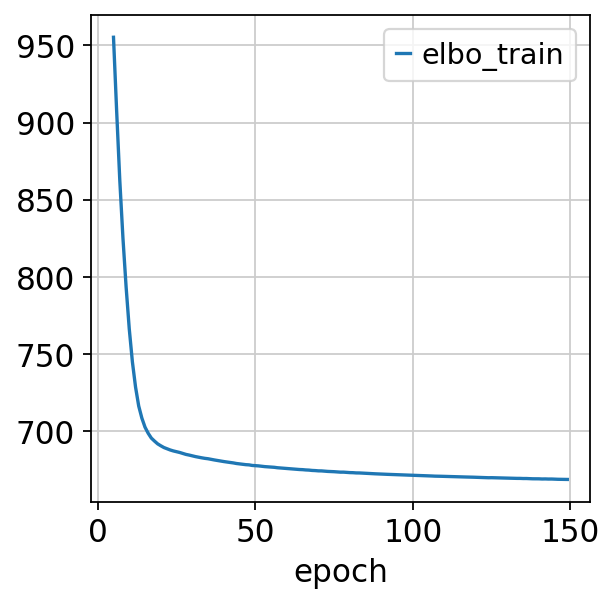

In [15]:
if False: # test mode
   sc_model.train(max_epochs=2)
   sc_model.history["elbo_train"].plot()
else: # normal mode
   sc_model.train(max_epochs=150)
   sc_model.history["elbo_train"].iloc[5:].plot()

plt.show()

save_model(sc_model, "output", "singlecell")
save_anndata(adata, "05", "trained")

## Annotation model training

We can now set up the single-cell model.

In [16]:
DestVI.setup_anndata(st_adata, layer="counts")
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

/usr/local/lib/python3.10/dist-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


Anndata setup with scvi-tools version 0.16.4.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 35049 │
│      n_vars      │ 1841  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

We train the model here.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1500/1500: 100%|██████████| 1500/1500 [59:07<00:00,  2.36s/it, loss=4.33e+06, v_num=1]


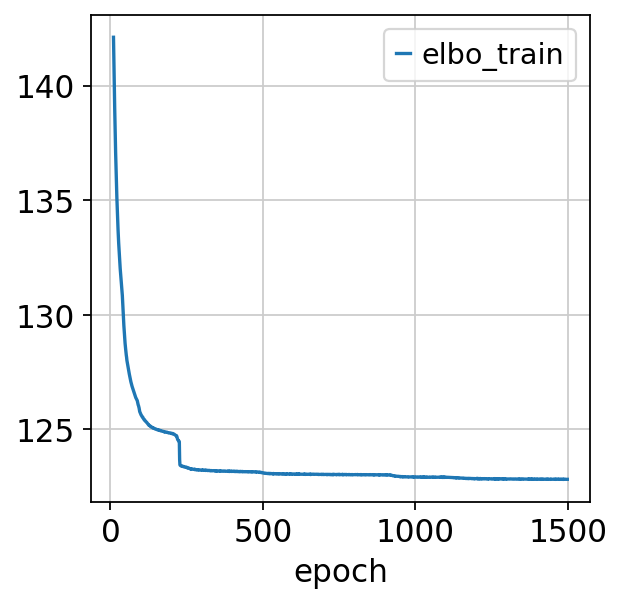

In [17]:
if False: # test mode
   st_model.train(max_epochs=2)
   st_model.history["elbo_train"].plot()
else: # normal mode
   st_model.train(max_epochs=1500)
   st_model.history["elbo_train"].iloc[10:].plot() 

plt.show()

st_adata.obsm["proportions"] = st_model.get_proportions()

save_model(st_model, "output", "spatial")
save_anndata(st_adata, "06", "proportions")

## Results

As a first approximation, we just select the max probability for each spot.

In [18]:
for cell_type in st_adata.obsm["proportions"].columns:
   data = st_adata.obsm["proportions"][cell_type].values
   st_adata.obs[cell_type] = np.clip(data, 0, np.quantile(data, 0.99))

st_adata.obs["CellType"] = st_adata.obsm["proportions"].idxmax(axis=1)

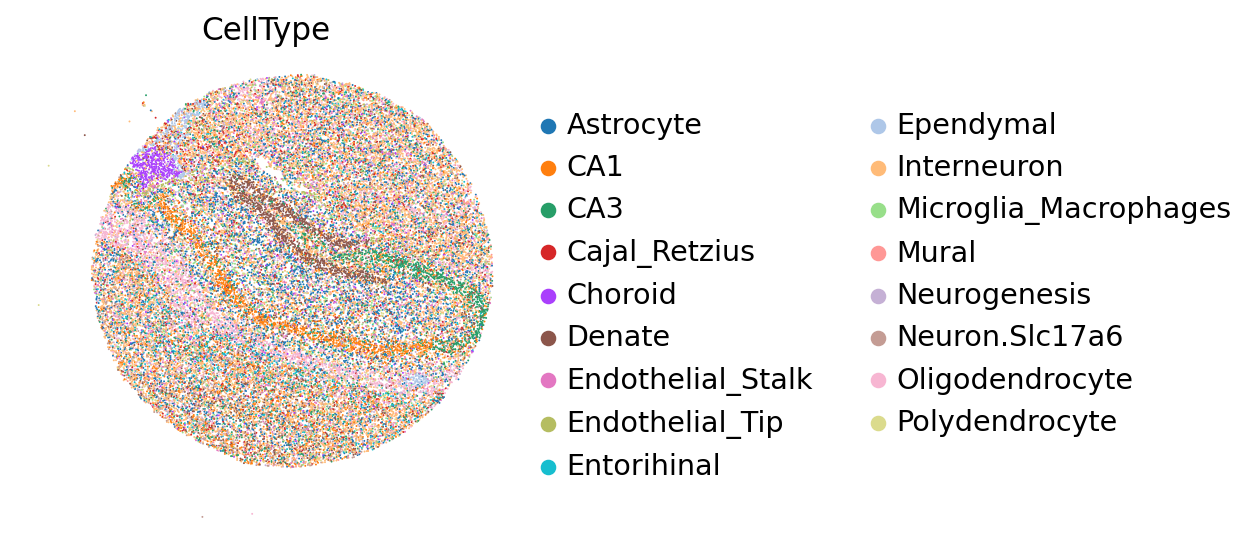

In [19]:
sc.settings.figdir = "output"
sc.settings.file_format_figs = "png" 

sc.pl.embedding(
   st_adata,
   basis="spatial",
   color="CellType",
   s=3,
   save=f".cell_type_all",
   show=True
   )

We plot the probability values for each cell type and for each spot.

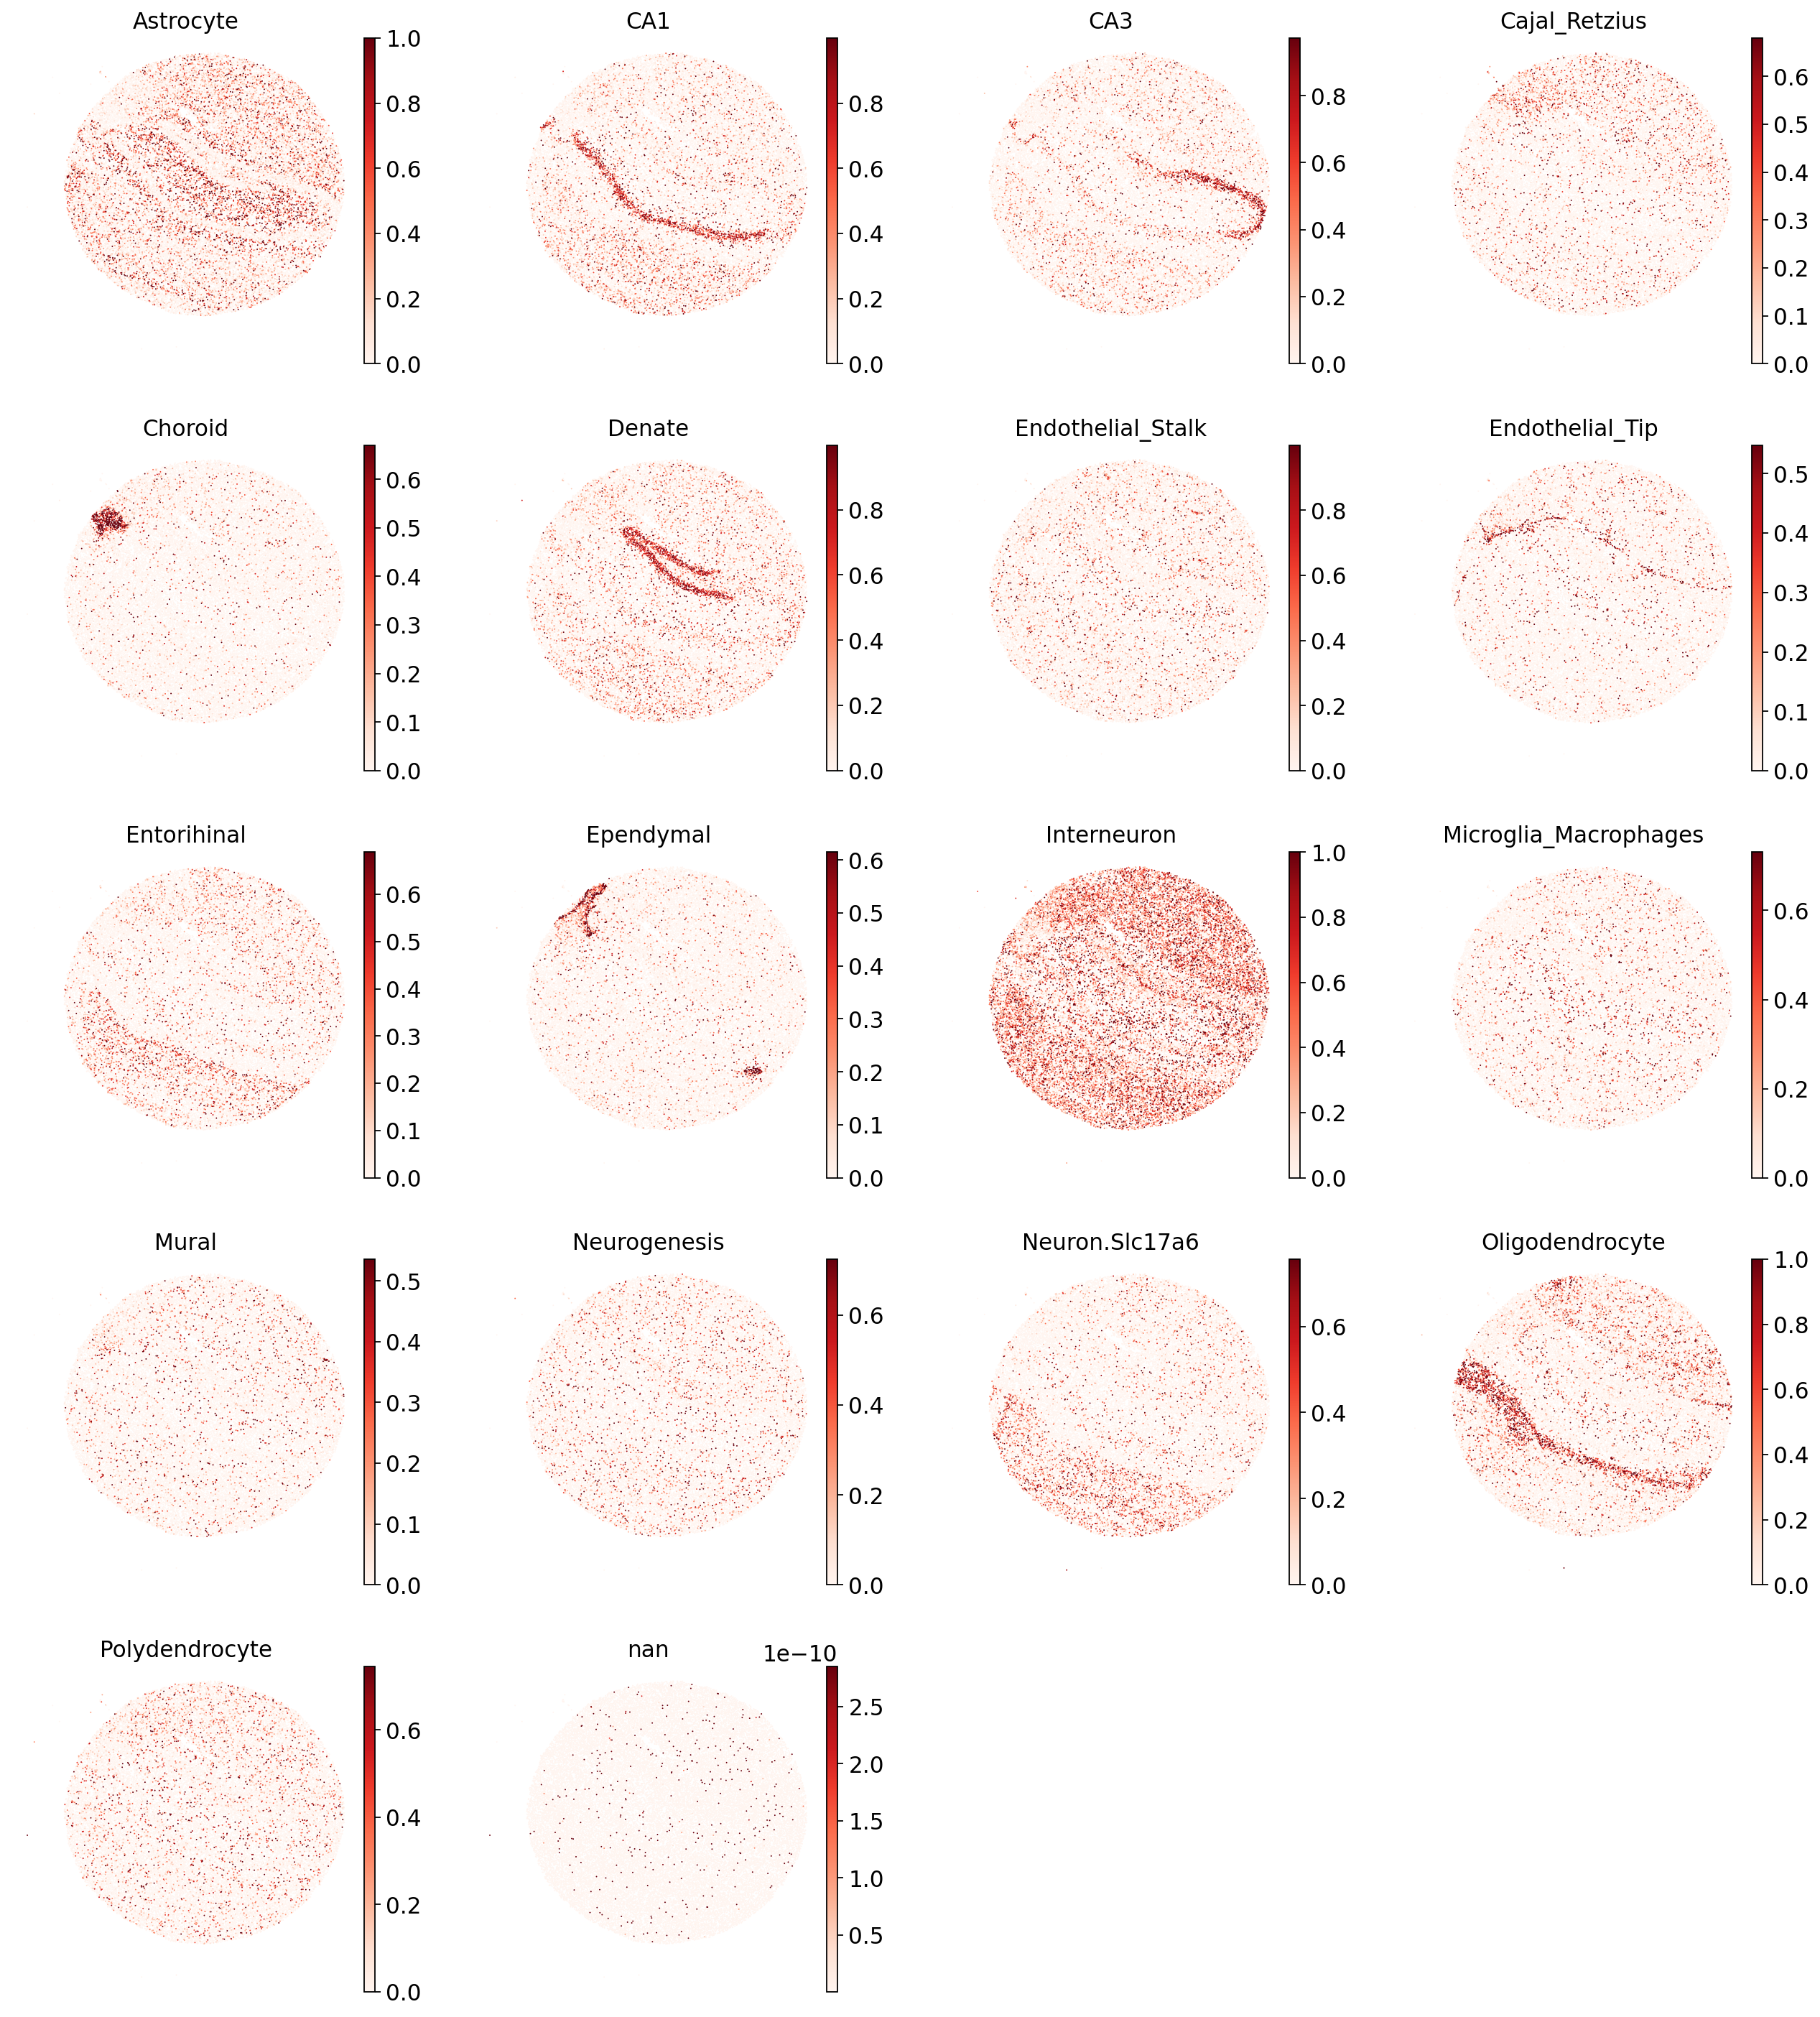

In [20]:
sc.settings.figdir = "output"
sc.settings.file_format_figs = "png" 

sc.pl.embedding(
   st_adata,
   basis="spatial",
   color=st_adata.obsm["proportions"].columns,
   cmap="Reds",
   s=3,
   save=f".cell_type_grid",
   show=True
   )

## Session info

In [21]:
session_info.show()